# Result data analyses from complex training
### Data fetched iether locally or from gdrive via oauth

In [1]:
# !rm -f *.png

## Compile Form in order to run the notebook

Forms provide an easy way to parameterize code. From a code cell, select Insert → Add form field. When you change the value in a form, the corresponding value in the code will change.

In [2]:
#@title Compile this form to run notebook:
import os
import warnings
warnings.filterwarnings("ignore", message="Numerical issues were encountered ")

#@markdown ---
#@markdown ##### Enter Root path:
root_path = "." # @param [".", /content/", "/content/drive/My Drive/Siren Deep Learning Analyses/results"]

#@markdown ---
#@markdown ##### Enter date and timestamp values:
# date_input = '2018-03-23' #@param {type:"date"}
date_input = '2020-10-17' #@param {type:"date"}
train_timestamp = "1602926490.052417" #@param {type:"string"}



#@markdown ---
#@markdown ##### Enter trial number:
train_no =  13 #@param {type:"integer", min:0, max:23, step:1}

#@markdown ---
#@markdown ##### Toggle checkbox to download resulting pictures:
download_pictures_checkbox = False #@param {type:"boolean"}

fetch_data_from_gdrive_checkbox = True #@param {type:"boolean"}

#@markdown ---
#@markdown ##### Enter dirname and image name:
dir_image = "/content/drive/My Drive/Siren Deep Learning Analyses/testsets/BSD68" # @param ["/content/", "/content/drive/My Drive/Siren Deep Learning Analyses/testsets/BSD68"]
image_name = "test068.png" #@param {type:"string"}

basedir_path_out_images = f"out_train_{train_no}" # @oaram ["/content", ".", out_train_{train_no}]

# if you get the shareable link, the link contains this id, replace the file_id below
file_id = '...'

## Authentication phase

In [3]:
from apiclient import discovery
from httplib2 import Http
import oauth2client
from oauth2client import file, client, tools
obj = lambda: None
lmao = {"auth_host_name":'localhost', 'noauth_local_webserver':'store_true', 'auth_host_port':[8080, 8090], 'logging_level':'ERROR'}
for k, v in lmao.items():
    setattr(obj, k, v)
    
# authorization boilerplate code
SCOPES = 'https://www.googleapis.com/auth/drive.readonly'
store = file.Storage('token.json')
creds = store.get()
# The following will give you a link if token.json does not exist, the link allows the user to give this app permission
if not creds or creds.invalid:
    flow = client.flow_from_clientsecrets('client_id.json', SCOPES)
    creds = tools.run_flow(flow, store, obj)

## Setup

### Installations

In [4]:
# !pip install -q gwpy

In [5]:
# Clean /content from trash or old .png images
# !rm -f /content/*.png

### Imports

In [6]:
from datetime import datetime
# from google.colab import files

from pathlib import Path
from collections import namedtuple  

# import psycopg2 as ps
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
# sns.set_theme(style="whitegrid")
import ipywidgets as widgets
# back end of ipywidgets
from IPython.display import display

import io
from googleapiclient.http import MediaIoBaseDownload
import zipfile

import collections
import functools
import glob
import operator
import os
import re
import numpy as np
import pandas as pd

### Setup output images full path

In [7]:
try: os.makedirs(basedir_path_out_images)
except: pass

In [8]:
image_kind_str = "df_scatter;scatter;bar;reg;point;box;violin;complex"
images_kind = list(map(lambda xx: f"{xx}plot", filter(lambda xx: len(xx) != 0, sorted(image_kind_str.split(";")))))

ImagesConf = namedtuple('ImagesConf', images_kind)

In [9]:
half_name = f"mse_psnr_et_al_vs_no_params_train_no_{train_no}.png"
def full_path_out_images(item, root_path = basedir_path_out_images, half_name = half_name):
    return os.path.join(root_path, f"{item}_{half_name}")

# image_names = list(map(lambda xx: f"{xx}_{half_name}", images_kind))
image_names = list(map(full_path_out_images, images_kind))

In [10]:
images_conf = ImagesConf._make(image_names)

### Functions

In [11]:
def graphics_bars_pointplot(dataframe, y_axes, x_axis, grid_shape, palette="Blues_d", axes = None, figsize = (15, 5), show_fig = False, title = 'Complex Plot'):
    fig, axes = plt.subplots(*grid_shape, figsize=figsize)
    fig.suptitle(f'{title}', fontsize=15)

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        pos = 0
        try:
            axes_list = functools.reduce(operator.iconcat, axes, [])
        except:
            axes_list = axes

        _ = graphics_scatterplot(
            dataframe = dataframe,
            y_axes = y_axes,
            axes = axes_list[len(y_axes) * pos:len(y_axes) * (pos+1)],
            x_axis = x_axis)
        """
        for ax in axes_list[len(y_axes) * pos:len(y_axes) * (pos+1)]:
            ax.get_xaxis().set_visible(False)
        """
        pos += 1

        _ = graphics_bars_mean_std(
            dataframe = dataframe,
            y_axes = y_axes,
            axes = axes_list[len(y_axes) * pos:len(y_axes) * (pos+1)],
            x_axis = x_axis)
    
        for ax in axes_list[len(y_axes) * pos:len(y_axes) * (pos+1)]:
            ax.get_xaxis().set_visible(False)
        pos += 1
    
        _ = graphics_pointplot_mean_std(
            dataframe = dataframe,
            y_axes = y_axes,
            axes = axes_list[len(y_axes) * pos:len(y_axes) * (pos+1)],
            x_axis = x_axis)

        for ax in axes_list[len(y_axes) * pos:len(y_axes) * (pos+1)]:
            ax.get_xaxis().set_visible(False)
        pos += 1
    
        _ = graphics_regplot_mean_std(
            dataframe = dataframe,
            y_axes = y_axes,
            axes = axes_list[len(y_axes) * pos:len(y_axes) * (pos+1)],
            x_axis = x_axis)
    
        for ax in axes_list[len(y_axes) * pos:len(y_axes) * (pos+1)]:
            ax.get_xaxis().set_visible(False)
        pos += 1

        _ = graphics_boxplot(
            dataframe = dataframe,
            y_axes = y_axes,
            axes = axes_list[len(y_axes) * pos:len(y_axes) * (pos+1)],
            x_axis = x_axis)


        for ax in axes_list[len(y_axes) * pos:len(y_axes) * (pos+1)]:
            ax.get_xaxis().set_visible(False)
        pos += 1
    
        _ = graphics_violinplot(
            dataframe = dataframe,
            y_axes = y_axes,
            axes = axes_list[len(y_axes) * pos:len(y_axes) * (pos+1)],
            x_axis = x_axis)
        pass
    return fig, axes

In [12]:
def graphics_scatterplot(dataframe, y_axes, x_axis, grid_shape = None, palette="Blues_d", axes = None, figsize = (15, 5), show_fig = False, title = 'Complex Plot'):
    flag = False
    fig = None
    if axes is None:
        fig, axes = plt.subplots(*grid_shape, figsize=figsize)
        fig.suptitle(f'{title}', fontsize=15)
        flag = True
        pass

    data_xtick_arr = \
        np.array(
            np.unique(dataframe[f"{x_axis}"].values),
            dtype=np.int
    )

    try:
        axes_list = functools.reduce(operator.iconcat, axes, [])
    except:
        axes_list = axes
    for ii, (ax, y_axis) in enumerate(zip(axes_list, y_axes)):
        # _ = sns.regplot(x=f"{x_axis}", y=(f"{y_axis}"), data=dataframe, order=1, ax = ax, marker = 'x', color = 'black', label = 'poly order 1°')
        # _ = sns.regplot(x=f"{x_axis}", y=(f"{y_axis}"), data=dataframe, order=2, ax = ax, marker = 'x', color = 'black', label = 'poly order 2°')

        _ = sns.scatterplot(x=f"{x_axis}", y=(f"{y_axis}"), data=dataframe, ax = ax, marker = 'x', color = sns.color_palette()[ii])
        # axes[0].get_yaxis().set_visible(False)
        ax.set_title(f'{y_axis.upper()}', fontsize=10)
        # ax.set_xticklabels(data_xtick_arr, rotation=45)
        # ax.set_xticklabels(data_xtick_arr, rotation=45)
        ax.set_xscale('log')
        pass

    # plt.tight_layout()
    if flag is False:
        return axes
    else:
        # plt.tight_layout()
        if show_fig: plt.show()
        return fig, axes

In [13]:
def graphics_violinplot(dataframe, y_axes, x_axis, grid_shape = None, palette="Blues_d", axes = None, figsize = (15, 5), show_fig = False, title = 'Complex Plot'):
    flag = False
    fig = None
    if axes is None:
        fig, axes = plt.subplots(*grid_shape, figsize=figsize)
        fig.suptitle(f'{title}', fontsize=15)
        flag = True
        pass

    data_xtick_arr = \
        np.array(
            np.unique(dataframe[f"{x_axis}"].values),
            dtype=np.int
    )

    try:
        axes_list = functools.reduce(operator.iconcat, axes, [])
    except:
        axes_list = axes
    for ax, y_axis in zip(axes_list, y_axes):
        _ = sns.violinplot(x=f"{x_axis}", y=(f"{y_axis}"), data=dataframe, ax = ax, palette="Set3", bw=.2, cut=1, linewidth=1)
        # axes[0].get_yaxis().set_visible(False)
        ax.set_title(f'{y_axis.upper()}', fontsize=10)
        ax.set_xticklabels(data_xtick_arr, rotation=45)
        # ax.set_yscale('log')
        pass

    # plt.tight_layout()
    if flag is False:
        return axes
    else:
        # plt.tight_layout()
        if show_fig: plt.show()
        return fig, axes

In [14]:
def graphics_boxplot(dataframe, y_axes, x_axis, grid_shape = None, palette="Blues_d", axes = None, figsize = (15, 5), show_fig = False, title = 'Complex Plot'):
    flag = False
    fig = None
    if axes is None:
        fig, axes = plt.subplots(*grid_shape, figsize=figsize)
        fig.suptitle(f'{title}', fontsize=15)
        flag = True
        pass

    data_xtick_arr = \
        np.array(
            np.unique(dataframe[f"{x_axis}"].values),
            dtype=np.int
    )

    try:
        axes_list = functools.reduce(operator.iconcat, axes, [])
    except:
        axes_list = axes
    for ax, y_axis in zip(axes_list, y_axes):
        _ = sns.boxplot(x=f"{x_axis}", y=(f"{y_axis}"),
            data=dataframe,
            palette=palette, ax = ax)
        # axes[0].get_yaxis().set_visible(False)
        ax.set_title(f'{y_axis.upper()}', fontsize=10)
        ax.set_xticklabels(data_xtick_arr, rotation=45)
        # ax.set_yscale('log')
        pass

    # plt.tight_layout()
    if flag is False:
        return axes
    else:
        # plt.tight_layout()
        if show_fig: plt.show()
        return fig, axes

In [15]:
def graphics_bars_mean_std(dataframe, y_axes, x_axis, grid_shape = None, palette="Blues_d", axes = None, figsize = (15, 5), show_fig = False, title = 'Complex Plot'):
    flag = False
    fig = None
    if axes is None:
        fig, axes = plt.subplots(*grid_shape, figsize=figsize)
        fig.suptitle(f'{title}', fontsize=15)
        flag = True
        pass

    data_xtick_arr = \
        np.array(
            np.unique(dataframe[f"{x_axis}"].values),
            dtype=np.int
    )

    try:
        axes_list = functools.reduce(operator.iconcat, axes, [])
    except:
        axes_list = axes
    for ax, y_axis in zip(axes_list, y_axes):
        _ = sns.barplot(x=f"{x_axis}", y=(f"{y_axis}"),
            data=dataframe,
            palette=palette,
            capsize=.0, ax = ax)
        # axes[0].get_yaxis().set_visible(False)
        ax.set_title(f'{y_axis.upper()} (mean+std)', fontsize=10)
        ax.set_xticklabels(data_xtick_arr, rotation=45)

    # plt.tight_layout()
    if flag is False:
        return axes
    else:
        # plt.tight_layout()
        if show_fig: plt.show()
        return fig, axes

In [16]:
def graphics_pointplot_mean_std(dataframe, y_axes, x_axis, grid_shape = None, palette=None, axes = None, figsize = (15, 5), show_fig = False, title = 'Complex Plot'):
    flag = False
    fig = None
    if axes is None:
        fig, axes = plt.subplots(*grid_shape, figsize=figsize)
        fig.suptitle(f'{title}', fontsize=15)
        flag = True
        pass

    data_xtick_arr = \
        np.array(
            np.unique(results_history_sorted_df[f"{x_axis}"].values),
            dtype=np.int
    )

    try:
        axes_list = functools.reduce(operator.iconcat, axes, [])
    except:
        axes_list = axes
    for ax, y_axis in zip(axes_list, y_axes):
        
        _ = sns.pointplot(x=f"{x_axis}", y=(f"{y_axis}"),
            data=dataframe,
            palette=palette,
            capsize=.0, ax = ax)
        # axes[0].get_yaxis().set_visible(False)
        ax.set_title(f'{y_axis.upper()} (mean+std)', fontsize=10)
        # ax.set_xticklabels(data_xtick_arr, rotation=45)
        ax.set_xscale('log')
        pass
    
    if flag is False:
        return axes
    else:
        # plt.tight_layout()
        if show_fig: plt.show()
        return fig, axes

In [17]:
def graphics_regplot_mean_std(dataframe, y_axes, x_axis, grid_shape = None, palette=None, axes = None, figsize = (15, 5), show_fig = False, title = 'Complex Plot'):
    flag = False
    fig = None
    if axes is None:
        fig, axes = plt.subplots(*grid_shape, figsize=figsize)
        fig.suptitle(f'{title}', fontsize=15)
        flag = True
        pass

    data_xtick_arr = \
        np.array(
            np.unique(dataframe[f"{x_axis}"].values),
            dtype=np.int
    )

    try:
        axes_list = functools.reduce(operator.iconcat, axes, [])
    except:
        axes_list = axes
    for ax, y_axis in zip(axes_list, y_axes):
        """
        _ = sns.regplot(x=f"{x_axis}", y=(f"{y_axis}"),
            data=dataframe, color = 'red', label = 'y_axis.upper()', ax = ax)
        """
        _ = sns.regplot(x=f"{x_axis}", y=(f"{y_axis}"), data=dataframe,
                label = f'{y_axis.upper()}',
                # scatter_kws={"s": 80},
                x_estimator=np.mean,
                ax = ax,
                order=4, ci=68)
        # axes[0].get_yaxis().set_visible(False)
        ax.set_title(f'{y_axis.upper()} | poly-regression order 4°', fontsize=10)
        # ax.set_xticklabels(data_xtick_arr, rotation=45)

    
    if flag is False:
        return axes
    else:
        # plt.tight_layout()
        if show_fig: plt.show()
        return fig, axes

In [18]:
def test_concat_arrays():
    res = np.concatenate(([[0, 1, 2]], [[3,4,5]]), axis = 0)
    res_2 = np.concatenate((res, [[5, 6, 7]]), axis = 0)
    res_2
    res_2.mean(axis = 0)
    res_3 = np.concatenate((res_2, [[8, 9, 10]]), axis = 0)
    res_3
    res_3.mean(axis = 0)
    pass

## Code

### Fetch Data

In [19]:
date_input_tmp = '-'.join([xx for xx in date_input.split('-')[::-1]])
train_timestamp_tmp = train_timestamp.replace('.', '-')
train_datetime = os.path.join(date_input_tmp, train_timestamp_tmp)

# print('Date train:', train_datetime)

if root_path == "/content":
    path_history_train = os.path.join(
        root_path,
        f'result_comb_train_{train_no}.txt')
elif root_path == ".":
    path_history_train = os.path.join(
        root_path,
        f'result_comb_train_{train_no}.txt')
else:
    path_history_train = os.path.join(
        root_path,
        train_datetime,
        "train",
        f'result_comb_train_{train_no}.txt')

print("Path location:")
print(path_history_train)

Path location:
.\result_comb_train_13.txt


In [20]:
if fetch_data_from_gdrive_checkbox:
    if os.path.exists(f'{path_history_train}') is False:
        DRIVE = discovery.build('drive', 'v3', http=creds.authorize(Http()))
        request = DRIVE.files().get_media(fileId=file_id)

        # replace the filename and extension in the first field below
        # fh = io.FileIO(f'filename.zip', mode='w')
        fh = io.FileIO(f'{path_history_train}', mode='w')
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while done is False:
            status, done = downloader.next_chunk()
            print("Download %d%%." % int(status.progress() * 100))
            pass
        pass
    pass

In [21]:
columns_df = ['#params', 'seed', 'hl', 'hf', 'mse', 'psnr', 'ssim', 'train_eta']

results_history_arr = np.loadtxt(path_history_train)

results_history_df = pd.DataFrame(
    data = results_history_arr,
    columns = columns_df)

### Dataframe: brief description

In [22]:
results_history_df.head(5)

,#params,seed,hl,hf,mse,psnr,ssim,train_eta
0,83073.0,0.0,5.0,128.0,0.016086,17.935392,0.743077,862.532200
1,83073.0,42.0,5.0,128.0,0.015902,17.985445,0.752657,858.288512
2,83073.0,123.0,5.0,128.0,0.015265,18.163124,0.752555,859.440255
3,99585.0,0.0,6.0,128.0,0.013129,18.817817,0.779338,1015.747737
4,99585.0,42.0,6.0,128.0,0.013781,18.607270,0.775464,1018.590972


In [23]:
results_history_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   #params    13 non-null     float64
 1   seed       13 non-null     float64
 2   hl         13 non-null     float64
 3   hf         13 non-null     float64
 4   mse        13 non-null     float64
 5   psnr       13 non-null     float64
 6   ssim       13 non-null     float64
 7   train_eta  13 non-null     float64
dtypes: float64(8)
memory usage: 960.0 bytes


In [24]:
results_history_df.describe()

,#params,seed,hl,hf,mse,psnr,ssim,train_eta
count,13.000000,13.000000,13.000000,13.0,13.000000,13.000000,13.000000,13.000000
mean,111016.384615,50.769231,6.692308,128.0,0.012127,19.282198,0.796031,1129.634770
std,21722.973022,53.279380,1.315587,0.0,0.002850,1.085399,0.039002,211.371970
min,83073.000000,0.000000,5.000000,128.0,0.007315,17.935392,0.743077,858.288512
25%,99585.000000,0.000000,6.000000,128.0,0.010298,18.549883,0.762536,1014.045726
50%,116097.000000,42.000000,7.000000,128.0,0.011812,19.276641,0.791698,1165.191269
75%,132609.000000,123.000000,8.000000,128.0,0.013964,19.872561,0.820262,1336.854564
max,149121.000000,123.000000,9.000000,128.0,0.016086,21.358102,0.858463,1499.459160


In [25]:
collections.Counter(results_history_df["hf"].values)

Counter({128.0: 13})

### Dataframe: in depth description

#### Scatter - Plot

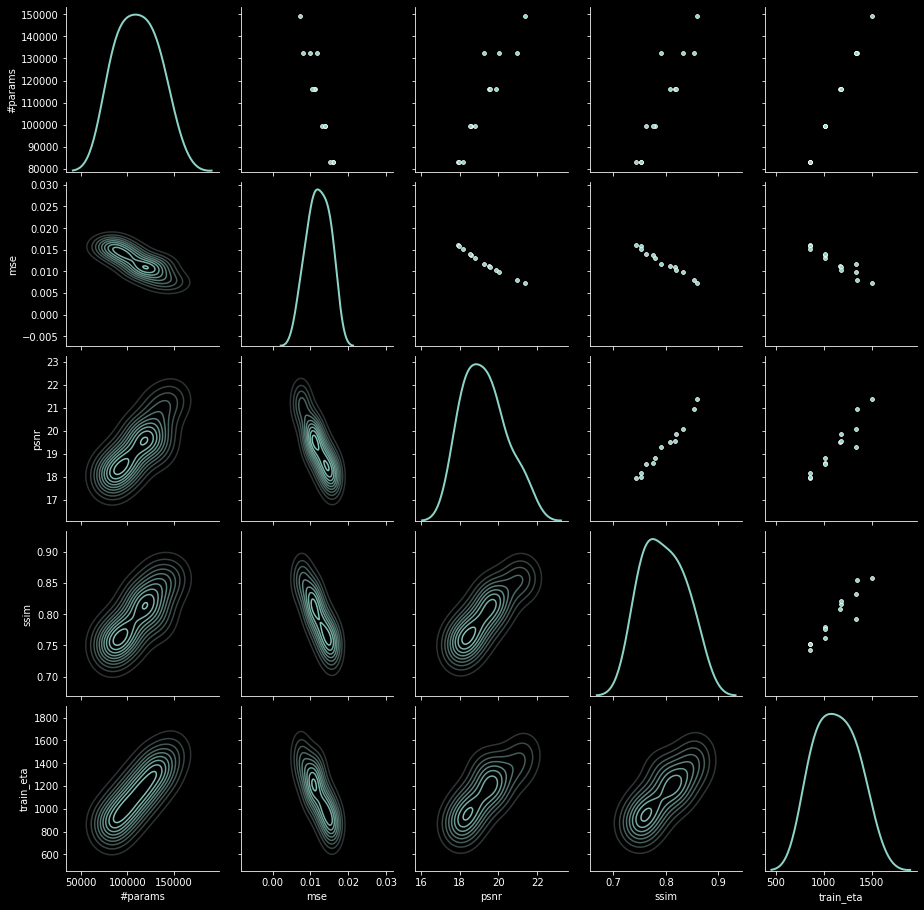

In [26]:
# sns.pairplot(results_history_df)
g = sns.PairGrid(results_history_df.drop(['hf', 'hl', 'seed'], axis = 1), diag_sharey=False)
g.map_upper(sns.scatterplot, s=15) # 
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)
# plt.savefig(f'scatter_plot_train_no_{train_no}.png')
plt.savefig(f'{images_conf.df_scatterplot}')

#### Plots

In [27]:
# Compute Mean and Standard-Deviation for MSE and PSNR
# with respect to data grouped by means of'#params'-attribute
#  within dataframe object: 'results_history_df

results_history_df.groupby(by = ['#params'])[['mse', 'psnr', 'ssim', 'train_eta']]\
    .describe()[[
                ("mse", "mean"), ("mse", "std"),
                ("psnr", "mean"), ("psnr", "std"),
                ("ssim", "mean"), ("ssim", "std"),
                ("train_eta", "mean"), ("train_eta", "std")
                ]]

mse                 psnr                ssim            \
              mean       std       mean       std      mean       std   
#params                                                                 
83073.0   0.015751  0.000431  18.027987  0.119678  0.749430  0.005502   
99585.0   0.013624  0.000439  18.658323  0.141075  0.772446  0.008798   
116097.0  0.010832  0.000465  19.655817  0.188710  0.815134  0.006133   
132609.0  0.009905  0.001889  20.094696  0.837260  0.826302  0.031922   
149121.0  0.007315       NaN  21.358102       NaN  0.858463       NaN   

            train_eta            
                 mean       std  
#params                          
83073.0    860.086989  2.194521  
99585.0   1016.128145  2.296377  
116097.0  1176.658176  9.960207  
132609.0  1342.390975  7.076503  
149121.0  1499.459160       NaN

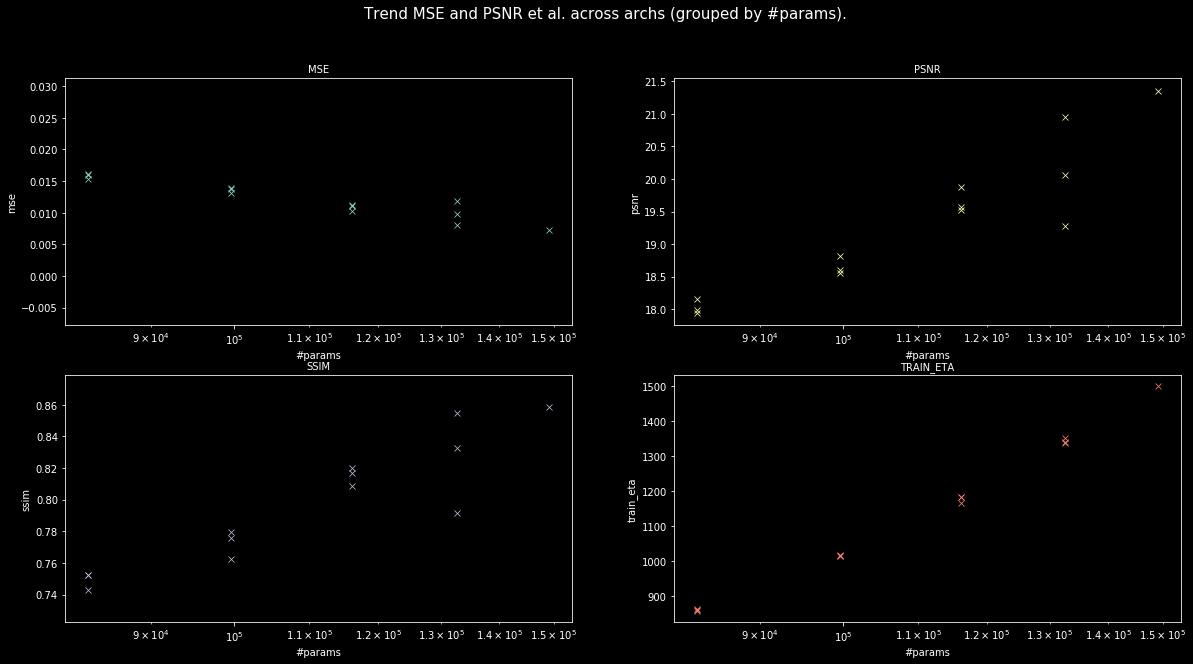

In [28]:
grid_shape = "(2, 2)" #@param ["(1, 4)", "(4, 1)", "(2, 2)"]
grid_shape = eval(grid_shape)

fig, axes = graphics_scatterplot(
    dataframe = results_history_df,
    y_axes = ("mse", "psnr", "ssim", "train_eta"),
    x_axis = "#params",
    grid_shape = grid_shape,
    figsize = (20, 10))
fig.suptitle('Trend MSE and PSNR et al. across archs (grouped by #params).', fontsize=15)
# plt.savefig(f"scatterplot_mse_psnr_et_al_vs_no_params_train_no_{train_no}.png")
plt.savefig(f"{images_conf.scatterplot}")

plt.show()

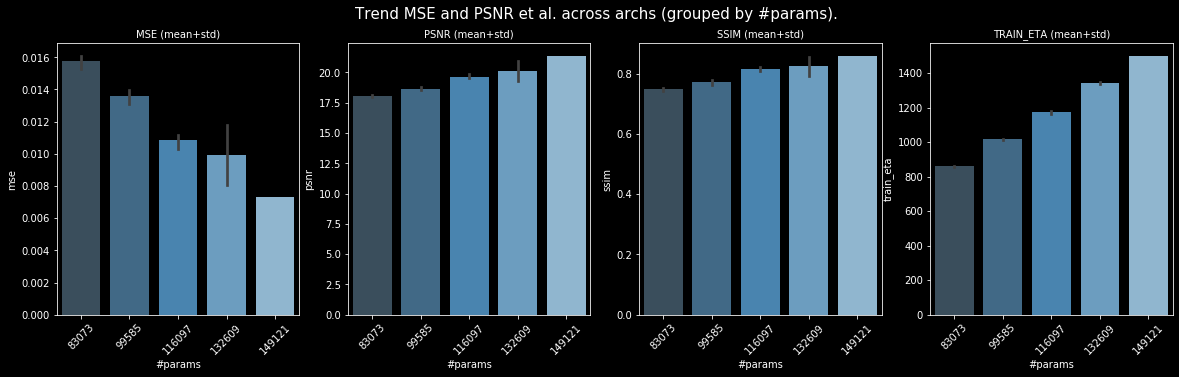

In [29]:
# %%capture
results_history_sorted_df = results_history_df.sort_values(by=['#params', 'hf', 'hl'])

grid_shape = "(1, 4)" #@param ["(1, 4)", "(4, 1)", "(2, 2)"]
grid_shape = eval(grid_shape)

fig, axes = graphics_bars_mean_std(
    dataframe = results_history_sorted_df,
    y_axes = ("mse", "psnr", "ssim", "train_eta"),
    x_axis = "#params",
    grid_shape = grid_shape,
    figsize = (20, 5))
fig.suptitle('Trend MSE and PSNR et al. across archs (grouped by #params).', fontsize=15)
# plt.savefig(f"bar_plot_mse_psnr_et_al_grouped_by_params_train_no_{train_no}.png")
plt.savefig(f"{images_conf.barplot}")
plt.show()

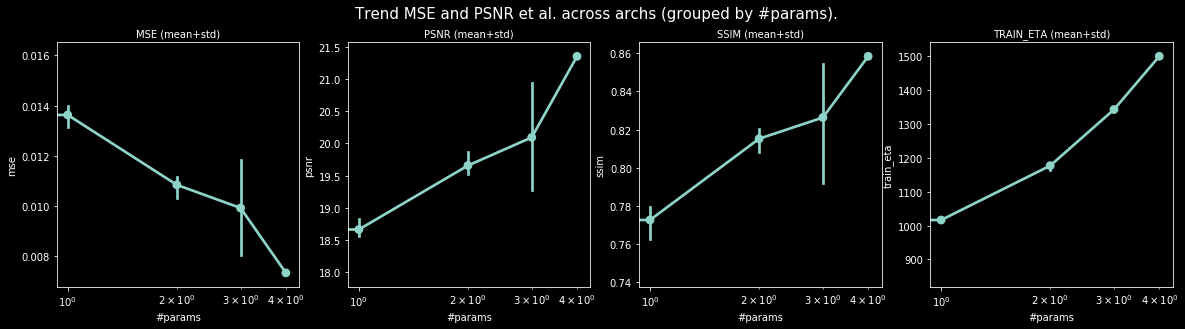

In [30]:
results_history_sorted_df = results_history_df.sort_values(by=['#params', 'hf', 'hl'])

grid_shape = "(1, 4)" #@param ["(1, 4)", "(4, 1)", "(2, 2)"]
grid_shape = eval(grid_shape)

fig, axes = graphics_pointplot_mean_std(
    dataframe = results_history_sorted_df,
    y_axes = ("mse", "psnr", "ssim", "train_eta"),
    x_axis = "#params",
    grid_shape = grid_shape, 
    figsize = (20, 5))
fig.suptitle('Trend MSE and PSNR et al. across archs (grouped by #params).', fontsize=15)
# plt.savefig(f"pointplot_mse_psnr_et_al_grouped_by_params_train_no_{train_no}.png")
plt.savefig(f"{images_conf.pointplot}")
plt.subplots_adjust(bottom = 0.2)
plt.show()

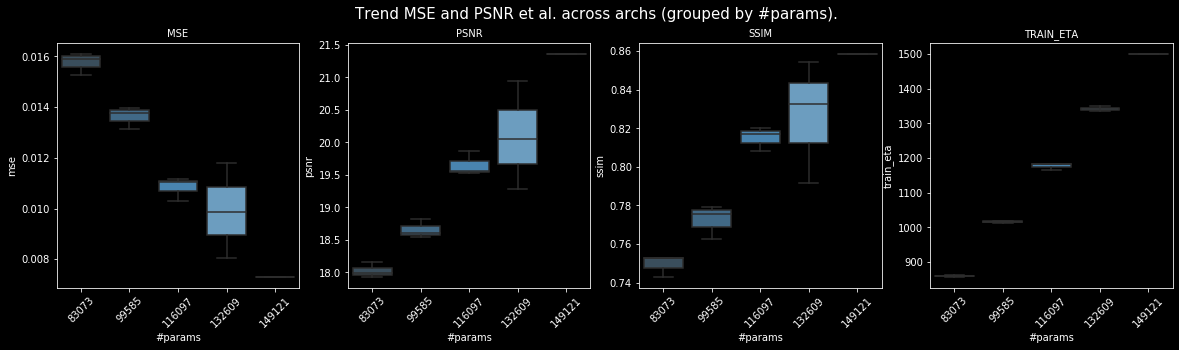

In [31]:
results_history_sorted_df = results_history_df.sort_values(by=['#params', 'hf', 'hl'])

grid_shape = "(1, 4)" #@param ["(1, 4)", "(4, 1)", "(2, 2)"]
grid_shape = eval(grid_shape)

fig, axes = graphics_boxplot(
    dataframe = results_history_sorted_df,
    y_axes = ("mse", "psnr", "ssim", "train_eta"),
    x_axis = "#params",
    grid_shape = grid_shape,
    figsize = (20, 5))
fig.suptitle('Trend MSE and PSNR et al. across archs (grouped by #params).', fontsize=15)
# plt.savefig(f"boxplot_mse_psnr_et_al_grouped_by_params_train_no_{train_no}.png")
plt.savefig(f"{images_conf.boxplot}")
plt.subplots_adjust(bottom = 0.2)
plt.show()

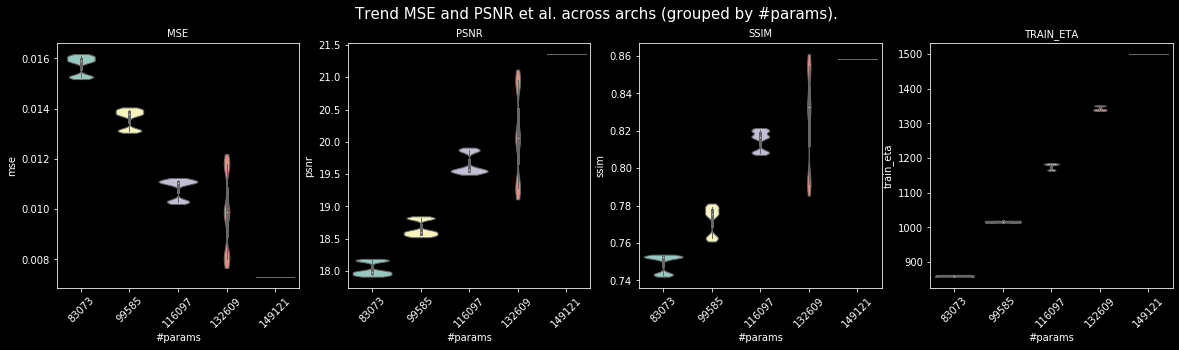

In [32]:
results_history_sorted_df = results_history_df.sort_values(by=['#params', 'hf', 'hl'])

grid_shape = "(1, 4)" #@param ["(1, 4)", "(4, 1)", "(2, 2)"]
grid_shape = eval(grid_shape)

fig, axes = None, None
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig, axes = graphics_violinplot(
        dataframe = results_history_sorted_df,
        y_axes = ("mse", "psnr", "ssim", "train_eta"),
        x_axis = "#params",
        grid_shape = grid_shape,
        figsize = (20, 5))
    pass
fig.suptitle('Trend MSE and PSNR et al. across archs (grouped by #params).', fontsize=15)
# plt.savefig(f"violinplot_mse_psnr_et_al_grouped_by_params_train_no_{train_no}.png")
plt.savefig(f"{images_conf.violinplot}")
plt.subplots_adjust(bottom = 0.2)
plt.show()

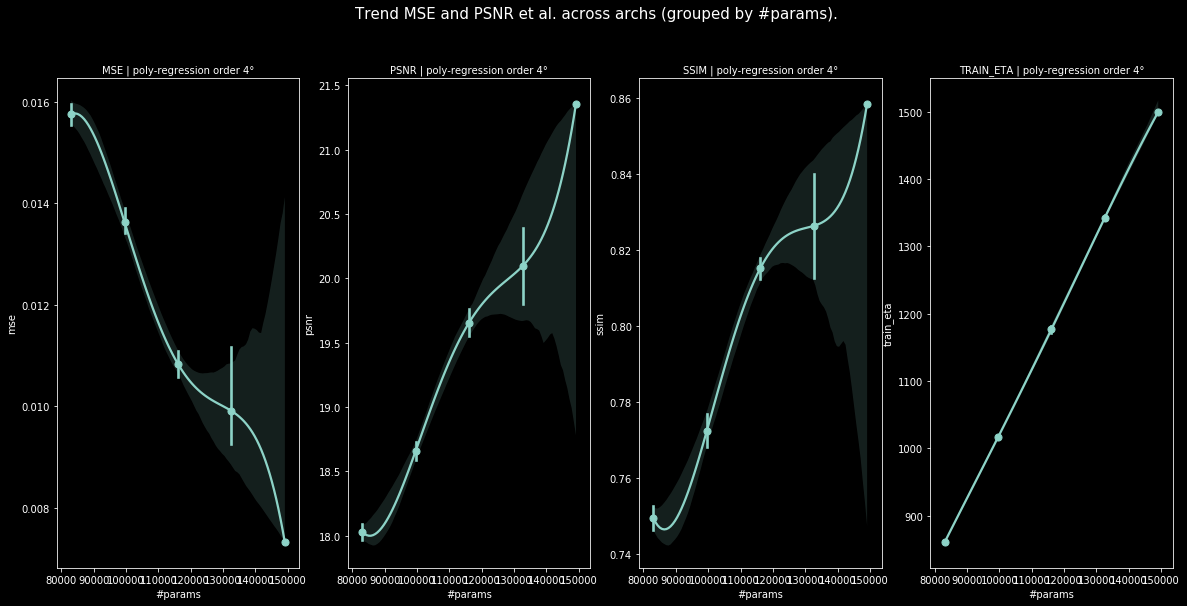

In [33]:
results_history_sorted_df = results_history_df.sort_values(by=['#params', 'hf', 'hl'])

grid_shape = "(1, 4)" #@param ["(1, 4)", "(4, 1)", "(2, 2)"]
grid_shape = eval(grid_shape)

fig, axes = None, None
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig, axes = graphics_regplot_mean_std(
        dataframe = results_history_sorted_df,
        y_axes = ("mse", "psnr", "ssim", "train_eta"),
        x_axis = "#params",
        grid_shape = grid_shape,
        figsize = (20, 10))
    pass
fig.suptitle('Trend MSE and PSNR et al. across archs (grouped by #params).', fontsize=15)
# plt.savefig(f"regplot_mse_psnr_et_al_grouped_by_params_train_no_{train_no}.png")
plt.savefig(f"{images_conf.regplot}")
plt.subplots_adjust(bottom = 0.2)
plt.show()

### Summary Graph

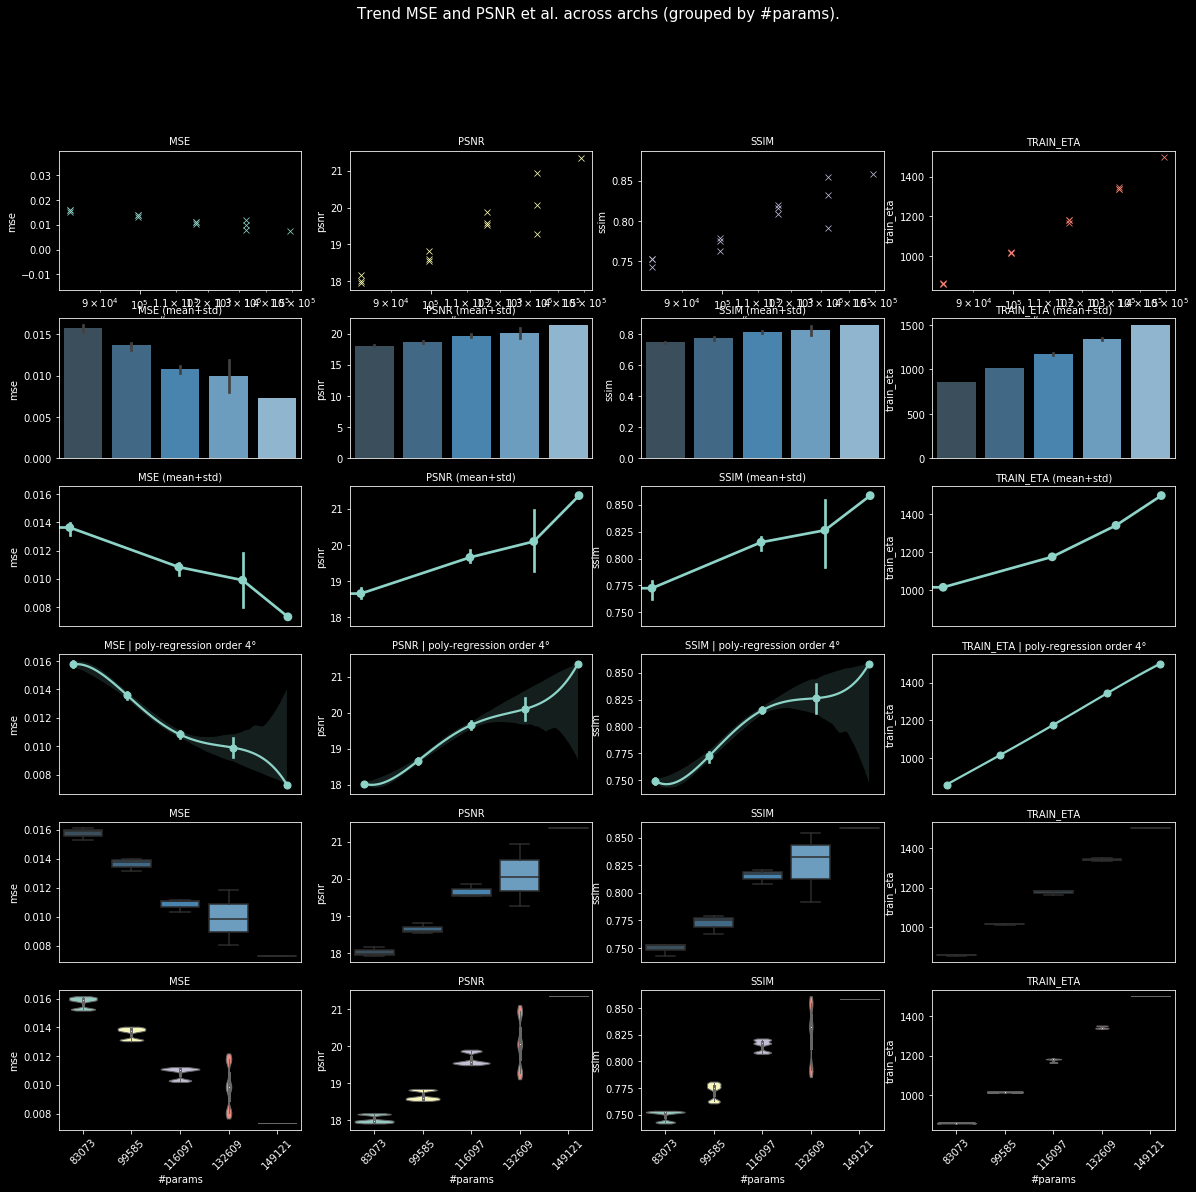

In [34]:
fig, axes = None, None
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig, axes = graphics_bars_pointplot(
        dataframe = results_history_sorted_df,
        y_axes = ("mse", "psnr", "ssim", "train_eta"),
        x_axis = "#params",
        grid_shape = (6, 4),
        figsize = (20, 20), palette="Blues_d",
        show_fig = False,
        title = 'Complex Plot')
    pass
fig.suptitle('Trend MSE and PSNR et al. across archs (grouped by #params).', fontsize=15)
# plt.savefig(f"complex_mse_psnr_et_al_grouped_by_params_train_no_{train_no}.png")
plt.savefig(f"{images_conf.complexplot}")
plt.subplots_adjust(bottom = 0.2)
# plt.tight_layout()
plt.show()

### Download files

In [35]:
print(f"Pictures ({len(list(Path(basedir_path_out_images).glob('*.png')))}):")
for path in Path(basedir_path_out_images).glob('*.png'):
    target_file = os.path.join(basedir_path_out_images, path.name)
    print(f"{target_file}")
    # if download_pictures_checkbox: files.download(target_file)
    pass

Pictures (8):
out_train_13\barplot_mse_psnr_et_al_vs_no_params_train_no_13.png
out_train_13\boxplot_mse_psnr_et_al_vs_no_params_train_no_13.png
out_train_13\complexplot_mse_psnr_et_al_vs_no_params_train_no_13.png
out_train_13\df_scatterplot_mse_psnr_et_al_vs_no_params_train_no_13.png
out_train_13\pointplot_mse_psnr_et_al_vs_no_params_train_no_13.png
out_train_13\regplot_mse_psnr_et_al_vs_no_params_train_no_13.png
out_train_13\scatterplot_mse_psnr_et_al_vs_no_params_train_no_13.png
out_train_13\violinplot_mse_psnr_et_al_vs_no_params_train_no_13.png


## References

- [FORM](https://colab.research.google.com/notebooks/forms.ipynb#scrollTo=3jKM6GfzlgpS)